<a href="https://colab.research.google.com/github/nuwanlakshitha/ML/blob/master/ML_xgboost_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [52]:
df = pd.read_csv('/content/drive/My Drive/ML/train.csv')
df

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct
17173,213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct
17174,213815405,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,6.94540,79.8768,6.93574,79.9010,133.31,correct


In [53]:
# df['pickup_time'] = pd.to_datetime(df['pickup_time'])
# df['drop_time'] = pd.to_datetime(df['drop_time'])
# df

def date_time_extractor(d):
  date_time_columns = ['drop_time', 'pickup_time']
  for column in date_time_columns:
    # d.insert(d.columns.get_loc(column), column+'_year', pd.DatetimeIndex(d[column]).year)
    # d.insert(d.columns.get_loc(column), column+'_month', pd.DatetimeIndex(d[column]).month)
    # d.insert(d.columns.get_loc(column), column+'_day', pd.DatetimeIndex(d[column]).day)
    d.insert(d.columns.get_loc(column), column+'_hour', pd.DatetimeIndex(d[column]).hour)
    d.insert(d.columns.get_loc(column), column+'_minute', pd.DatetimeIndex(d[column]).minute)
    del d[column]

date_time_extractor(df)
df

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time_hour,pickup_time_minute,drop_time_hour,drop_time_minute,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,0,20,0,34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,0,56,1,9,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,1,8,1,26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,2,27,2,37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,3,34,3,51,6.87441,79.8615,6.84478,79.9290,358.39,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,213803193,10.5,838.0,93.0,5.4219,451.0,22,7,22,21,7.29073,80.6367,7.28891,80.6557,198.26,correct
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,23,7,23,43,6.90569,79.8516,6.95089,79.9389,581.23,correct
17173,213813930,10.5,263.0,9.0,0.0000,110.0,23,21,23,25,7.09210,79.9000,7.10135,79.9017,76.20,correct
17174,213815405,10.5,858.0,115.0,0.0000,317.0,23,39,23,53,6.94540,79.8768,6.93574,79.9010,133.31,correct


In [54]:
from math import sin, cos, sqrt, atan2, radians

def distance_calculator(d):
  distances = []
  for index, record in d.iterrows():
    lat1 = radians(record['pick_lat'])
    lon1 = radians(record['pick_lon'])
    lat2 = radians(record['drop_lat'])
    lon2 = radians(record['drop_lon'])
    d_lat = lat2-lat1
    d_lon = lon2-lon1

    a = sin(d_lat/2)**2 +cos(lat1)*cos(lat2)*sin(d_lon/2)**2
    c = 2*atan2(sqrt(a), sqrt(1-a))

    distances.append(round(6373*c, 2))
  del d['pick_lat']
  del d['pick_lon']
  del d['drop_lat']
  del d['drop_lon']
  return distances

distances = distance_calculator(df)
df.insert(df.columns.get_loc('fare'), 'distance', distances)
df

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time_hour,pickup_time_minute,drop_time_hour,drop_time_minute,distance,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,0,20,0,34,5.09,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,0,56,1,9,3.17,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,1,8,1,26,6.31,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,2,27,2,37,0.86,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,3,34,3,51,8.15,358.39,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,213803193,10.5,838.0,93.0,5.4219,451.0,22,7,22,21,2.11,198.26,correct
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,23,7,23,43,10.87,581.23,correct
17173,213813930,10.5,263.0,9.0,0.0000,110.0,23,21,23,25,1.05,76.20,correct
17174,213815405,10.5,858.0,115.0,0.0000,317.0,23,39,23,53,2.88,133.31,correct


In [55]:
df.replace(to_replace=['correct', 'incorrect'], value=[1, 0], inplace=True)
df['label'].value_counts()

1    15495
0     1681
Name: label, dtype: int64

In [56]:
df = df.drop(['tripid'], axis=1)
# del df['drop_time']
# del df['pickup_time']
# del df['pick_lat']
# del df['pick_lon']
# del df['drop_lat']
# del df['drop_lon']
df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time_hour,pickup_time_minute,drop_time_hour,drop_time_minute,distance,fare,label
0,10.5,834.0,56.0,0.0000,64.0,0,20,0,34,5.09,270.32,1
1,10.5,791.0,47.0,0.0000,134.0,0,56,1,9,3.17,197.85,1
2,10.5,1087.0,80.0,0.0000,61.0,1,8,1,26,6.31,301.64,1
3,10.5,598.0,271.0,15.6638,68.0,2,27,2,37,0.86,82.30,1
4,NaN,NaN,NaN,NaN,NaN,3,34,3,51,8.15,358.39,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17171,10.5,838.0,93.0,5.4219,451.0,22,7,22,21,2.11,198.26,1
17172,10.5,2151.0,428.0,0.0000,39.0,23,7,23,43,10.87,581.23,1
17173,10.5,263.0,9.0,0.0000,110.0,23,21,23,25,1.05,76.20,1
17174,10.5,858.0,115.0,0.0000,317.0,23,39,23,53,2.88,133.31,1


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


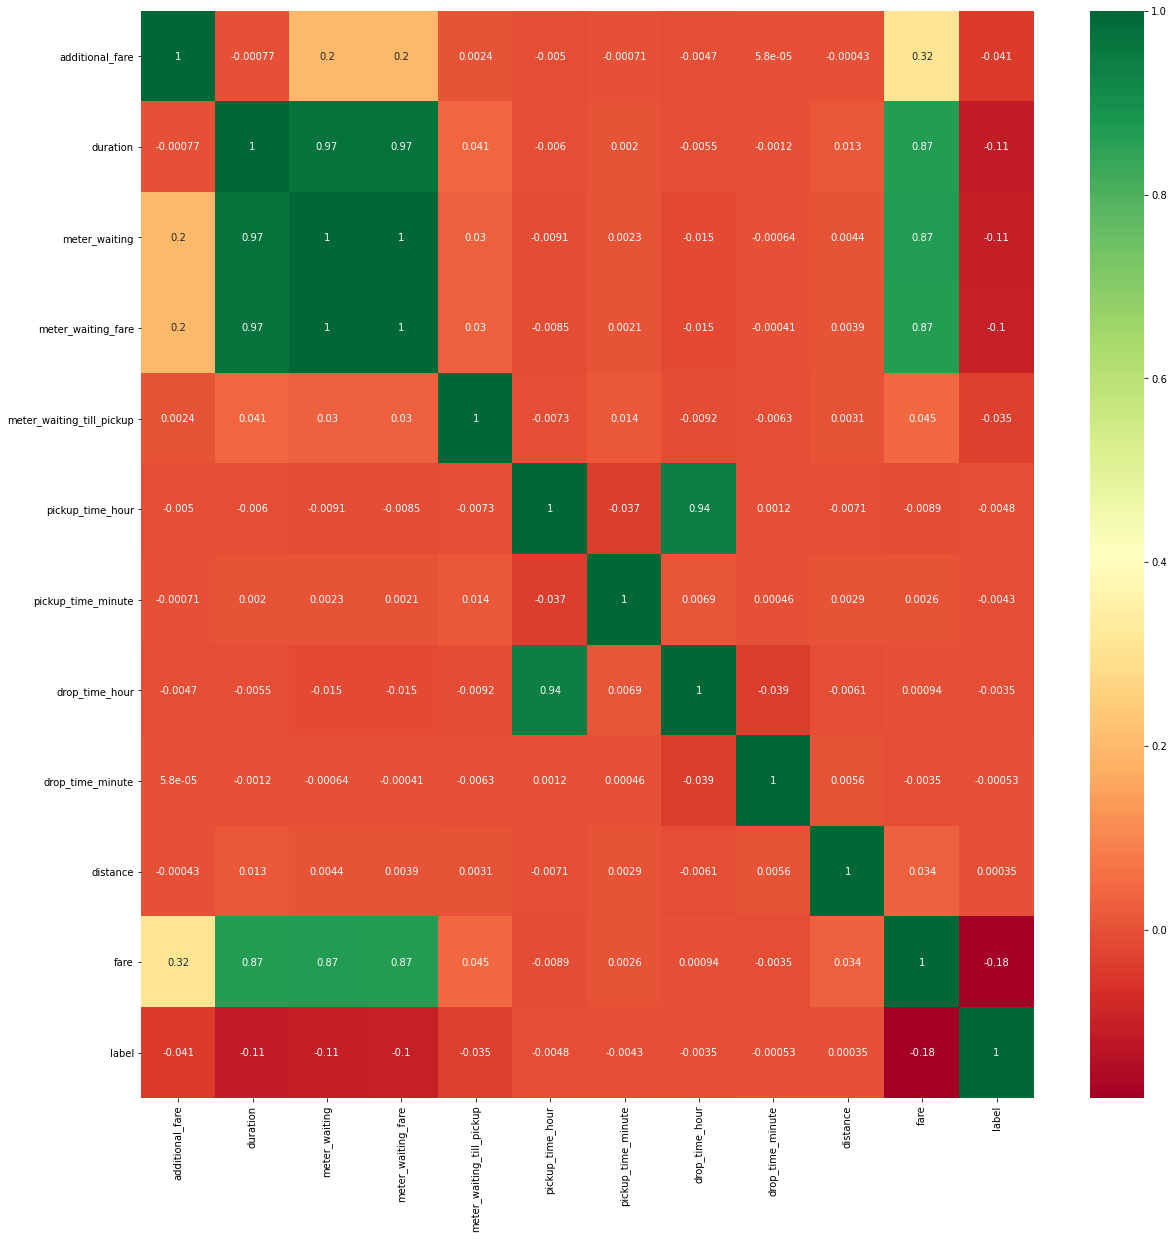

In [45]:
## Correlation
import seaborn as sns
import matplotlib.pyplot as plt
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [57]:
X = df.columns
X = df[X[0:len(df.columns)-1]]
X

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time_hour,pickup_time_minute,drop_time_hour,drop_time_minute,distance,fare
0,10.5,834.0,56.0,0.0000,64.0,0,20,0,34,5.09,270.32
1,10.5,791.0,47.0,0.0000,134.0,0,56,1,9,3.17,197.85
2,10.5,1087.0,80.0,0.0000,61.0,1,8,1,26,6.31,301.64
3,10.5,598.0,271.0,15.6638,68.0,2,27,2,37,0.86,82.30
4,NaN,NaN,NaN,NaN,NaN,3,34,3,51,8.15,358.39
...,...,...,...,...,...,...,...,...,...,...,...
17171,10.5,838.0,93.0,5.4219,451.0,22,7,22,21,2.11,198.26
17172,10.5,2151.0,428.0,0.0000,39.0,23,7,23,43,10.87,581.23
17173,10.5,263.0,9.0,0.0000,110.0,23,21,23,25,1.05,76.20
17174,10.5,858.0,115.0,0.0000,317.0,23,39,23,53,2.88,133.31


In [58]:
y = df['label'].values
y

array([1, 1, 1, ..., 1, 1, 1])

In [0]:
from numpy import nan
from numpy import isnan
from sklearn.impute import SimpleImputer

imp_features = [['additional_fare', 'duration', 'meter_waiting', 'fare']]
imp_features2 = [['meter_waiting_fare', 'meter_waiting_till_pickup']]

for feature in imp_features2:
  imputer = SimpleImputer(missing_values=nan, strategy='most_frequent')
  X[feature] = imputer.fit_transform(X[feature].values)

for feature in imp_features:
  imputer = SimpleImputer(missing_values=nan, strategy='mean')
  X[feature] = imputer.fit_transform(X[feature].values)
X

In [0]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
# X_train

In [0]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]   
}

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

classifier=xgboost.XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X,y)

In [60]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [61]:
random_search.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 7}

In [62]:
from xgboost import XGBClassifier
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
model.fit(X, y)
# model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# from sklearn.metrics import jaccard_similarity_score
# from sklearn.metrics import f1_score
# from sklearn.metrics import log_loss
# from sklearn.model_selection import cross_val_score
# from sklearn.neighbors import KNeighborsClassifier

# X_train, y_train = X,y

# bestScore=0.0
# accList=[]
# for k in range(1,15):
#     clf_knn = KNeighborsClassifier(n_neighbors=k,algorithm='auto')
    
#     scores = cross_val_score(clf_knn, X_train, y_train, cv=10)
#     score=scores.mean()
#     accList.append(score)
    
#     if score > bestScore:
#         bestScore=score
#         best_clf=clf_knn
#         bestK=k
# print("Best K is :",bestK,"| Cross validation Accuracy :",bestScore)
# clf_knn=best_clf

In [0]:
# clf_knn.fit(X_train,y_train)
# y_pred=best_clf.predict(X_train)
# trainScores={}

In [0]:
# trainScores['KNN-jaccard']=jaccard_similarity_score(y_train, y_pred)
# trainScores['KNN-f1-score']=f1_score(y_train, y_pred, average='weighted')
# trainScores

In [0]:
# plt.plot(range(1,15),accList)
# plt.xlabel('K')
# plt.ylabel('CV Accuracy')
# plt.show()

In [0]:
# from sklearn.metrics import roc_auc_score

# knn_pred=model.predict(X_test)
# roc_auc_score(y_test, knn_pred)

In [63]:
test_df = pd.read_csv('/content/drive/My Drive/ML/test.csv')
test_X = test_df[test_df.columns]
test_X

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
0,213284604,10.5,924,42,2.44860,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
1,213286352,10.5,4249,20,0.00000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
2,213293973,10.5,1552,255,2.65880,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
3,213294622,10.5,462,16,0.00000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
4,213298687,10.5,814,392,12.36920,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8571,222856243,10.5,1723,429,24.83332,3,3/16/2020 21:28,3/16/2020 21:56,6.85103,79.9567,6.85588,79.9214,388.48
8572,222857785,10.5,1378,80,0.00000,125,3/16/2020 21:59,3/16/2020 22:22,6.91293,79.9656,6.92112,79.8980,379.85
8573,222858416,10.5,418,56,3.28440,93,3/16/2020 22:02,3/16/2020 22:09,6.85718,79.9081,6.83868,79.9083,112.79
8574,222858691,10.5,1604,548,31.67440,17,3/16/2020 22:07,3/16/2020 22:34,6.91289,79.8846,6.93159,79.9145,248.46


In [64]:
date_time_extractor(test_X)
dist = distance_calculator(test_X)
test_X.insert(test_X.columns.get_loc('fare'), 'distance', dist)
del test_X['tripid']
test_X

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time_hour,pickup_time_minute,drop_time_hour,drop_time_minute,distance,fare
0,10.5,924,42,2.44860,148,0,38,0,53,6.71,289.27
1,10.5,4249,20,0.00000,91,1,2,2,13,41.57,1912.70
2,10.5,1552,255,2.65880,23,5,2,5,28,5.92,394.00
3,10.5,462,16,0.00000,198,5,30,5,38,3.30,154.32
4,10.5,814,392,12.36920,69,7,0,7,14,2.59,147.47
...,...,...,...,...,...,...,...,...,...,...,...
8571,10.5,1723,429,24.83332,3,21,28,21,56,3.94,388.48
8572,10.5,1378,80,0.00000,125,21,59,22,22,7.52,379.85
8573,10.5,418,56,3.28440,93,22,2,22,9,2.06,112.79
8574,10.5,1604,548,31.67440,17,22,7,22,34,3.90,248.46


In [0]:
# test_X['drop_time'] = pd.to_datetime(test_X['drop_time'])
# test_X['pickup_time'] = pd.to_datetime(test_X['pickup_time'])

In [0]:
# imp_features = [['additional_fare','duration','meter_waiting','meter_waiting_fare','meter_waiting_till_pickup','pick_lat','pick_lon','drop_lat','drop_lon','fare']]

# for feature in imp_features:
#   imputer = SimpleImputer(missing_values=nan, strategy='mean')
#   transformed_values = imputer.fit_transform(test_df[feature].values)
# test_df

In [0]:
# test_df['duration'] = test_df['duration'].astype(np.float64)
# test_df['meter_waiting'] = test_df['meter_waiting'].astype(np.float64)
# test_df['meter_waiting_till_pickup'] = test_df['meter_waiting_till_pickup'].astype(np.float64)
# test_df

In [0]:
# test_df['label'] = pd.to_numeric(test_df['label'])
# test_df

In [65]:
xgb_pred = model.predict(test_X)
test_df['prediction'] = xgb_pred
test_df

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,prediction
0,213284604,10.5,924,42,2.44860,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27,1
1,213286352,10.5,4249,20,0.00000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70,1
2,213293973,10.5,1552,255,2.65880,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00,1
3,213294622,10.5,462,16,0.00000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32,1
4,213298687,10.5,814,392,12.36920,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8571,222856243,10.5,1723,429,24.83332,3,3/16/2020 21:28,3/16/2020 21:56,6.85103,79.9567,6.85588,79.9214,388.48,1
8572,222857785,10.5,1378,80,0.00000,125,3/16/2020 21:59,3/16/2020 22:22,6.91293,79.9656,6.92112,79.8980,379.85,1
8573,222858416,10.5,418,56,3.28440,93,3/16/2020 22:02,3/16/2020 22:09,6.85718,79.9081,6.83868,79.9083,112.79,1
8574,222858691,10.5,1604,548,31.67440,17,3/16/2020 22:07,3/16/2020 22:34,6.91289,79.8846,6.93159,79.9145,248.46,1


In [0]:
# knn_pred=clf_knn.predict(test_X)
# test_df['prediction'] = knn_pred
# test_df

In [66]:
test_df['prediction'].value_counts()

1    8238
0     338
Name: prediction, dtype: int64

In [67]:
submission_df = test_df[['tripid','prediction']]
submission_df

,tripid,prediction
0,213284604,1
1,213286352,1
2,213293973,1
3,213294622,1
4,213298687,1
...,...,...
8571,222856243,1
8572,222857785,1
8573,222858416,1
8574,222858691,1


In [0]:
submission_df.to_csv('/content/drive/My Drive/ML/submission_10.csv', index=True)